In [5]:
import numpy as np
from shared.lsh_forest import LSHForest, BitSamplingLSH


d = 64                                   # vector dimension
n = 10_000                               # synthetic dataset size
rng = np.random.default_rng(42)
vectors = rng.integers(0, 2, size=(n, d), dtype=np.uint8)

forest = LSHForest(BitSamplingLSH(d), l=12, k=4, km=32)
forest.batch_insert(vectors)

q = vectors[123] ^ rng.integers(0, 2, d, dtype=np.uint8)  # make a noisy copy
nn = forest.query(q, m=5)
print("nearest:", nn[:3])


nearest: [(3911, 17), (1431, 19), (6534, 22)]


In [6]:
# 1) Show LSH collision probability: close vs far
d=64; r_close=8; r_far=32
lsh=BitSamplingLSH(d)
trials=10000
collide_close=0; collide_far=0
for _ in range(trials):
    x=np.random.randint(0,2,d,np.uint8)
    y=x.copy()
    flip=np.random.choice(d,r_close,replace=False)
    y[flip]^=1
    z=x.copy()
    flip2=np.random.choice(d,r_far,replace=False)
    z[flip2]^=1
    h=lsh.sample()
    if h(x)==h(y): collide_close+=1
    if h(x)==h(z): collide_far+=1
print(f"Collision prob close (dist {r_close}): {collide_close/trials:.3f}")
print(f"Collision prob far   (dist {r_far}): {collide_far/trials:.3f}")

# 2) Build forest, check nearest neighbor recall
n=5000
vectors=np.random.randint(0,2,(n,d),np.uint8)
forest=LSHForest(BitSamplingLSH(d),l=12,k=4,km=32)
forest.batch_insert(vectors)

# choose 50 random queries: each is a noisy version of a true vector
def brute_nn(q):
    dists=np.count_nonzero(vectors!=q,axis=1)
    idx=np.argmin(dists)
    return idx,dists[idx]
hits=0
for _ in range(50):
    base_idx=np.random.randint(0,n)
    q=vectors[base_idx].copy()
    noise_bits=np.random.choice(d,6,replace=False)
    q[noise_bits]^=1
    true_idx,true_dist=brute_nn(q)
    found_idx,_=forest.query(q,1)[0]
    if found_idx==true_idx:
        hits+=1
print(f"Exact NN retrieved in {hits}/50 queries ({hits*2}%)")

Collision prob close (dist 8): 0.877
Collision prob far   (dist 32): 0.499
Exact NN retrieved in 50/50 queries (100%)


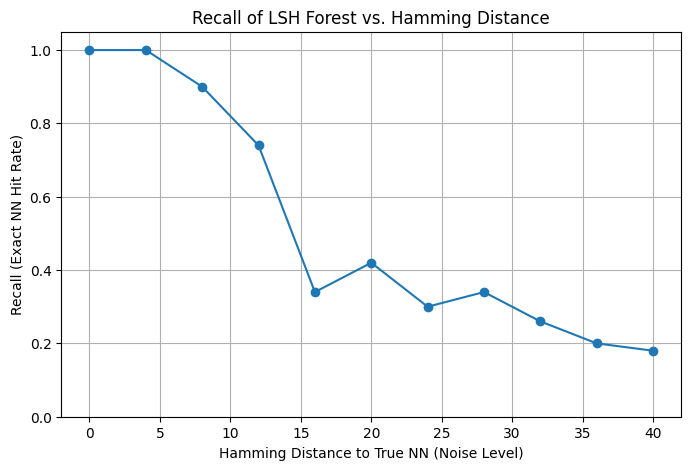

In [7]:
import matplotlib.pyplot as plt

# Try a range of Hamming noise levels, record NN recall
d = 64
n = 5000
vectors = np.random.randint(0, 2, (n, d), dtype=np.uint8)
forest = LSHForest(BitSamplingLSH(d), l=12, k=4, km=32)
forest.batch_insert(vectors)

noise_levels = list(range(0, 41, 4))  # from 0 to 40 flipped bits
recalls = []

def brute_nn(q):
    dists = np.count_nonzero(vectors != q, axis=1)
    idx = np.argmin(dists)
    return idx, dists[idx]

for noise in noise_levels:
    hits = 0
    for _ in range(50):
        base_idx = np.random.randint(0, n)
        q = vectors[base_idx].copy()
        flip = np.random.choice(d, min(noise, d), replace=False)
        q[flip] ^= 1
        true_idx, _ = brute_nn(q)
        found_idx, _ = forest.query(q, 1)[0]
        if found_idx == true_idx:
            hits += 1
    recalls.append(hits / 50)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, recalls, marker='o')
plt.title("Recall of LSH Forest vs. Hamming Distance")
plt.xlabel("Hamming Distance to True NN (Noise Level)")
plt.ylabel("Recall (Exact NN Hit Rate)")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()
